In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
save_plot = False

# Entropies

In [10]:
def process_entropy(filename, calc_ent = 'ap'):
    '''
    Selects entropies based on user input, melts imported dataframe
    and returns it so user can use catplot.
    
    calc_ent: 'ap' or 'sam'
    '''
    ent = pd.read_excel(f'entropies/{filename}.xlsx')
    ent['group'] = ent['unique_id'].apply(lambda x: 'control' if 'cecon' in x else 'pd')

    ent_col = [col for col in ent.columns if (f'{calc_ent}-' in col) & ('elbow' not in col)]
    ent_col.sort()
    ent = ent[['unique_id','group','dance_group','time'] + ent_col]

    ent_melt = ent.melt(id_vars = ['unique_id','group','dance_group','time'])
    return ent_melt, ent

# Approximate Entropy

## With calculated Tau

In [11]:
var_melt, var = process_entropy('varying_lag_entropy')

/home/jupyter-pomkos/.conda/envs/data_env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 35.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


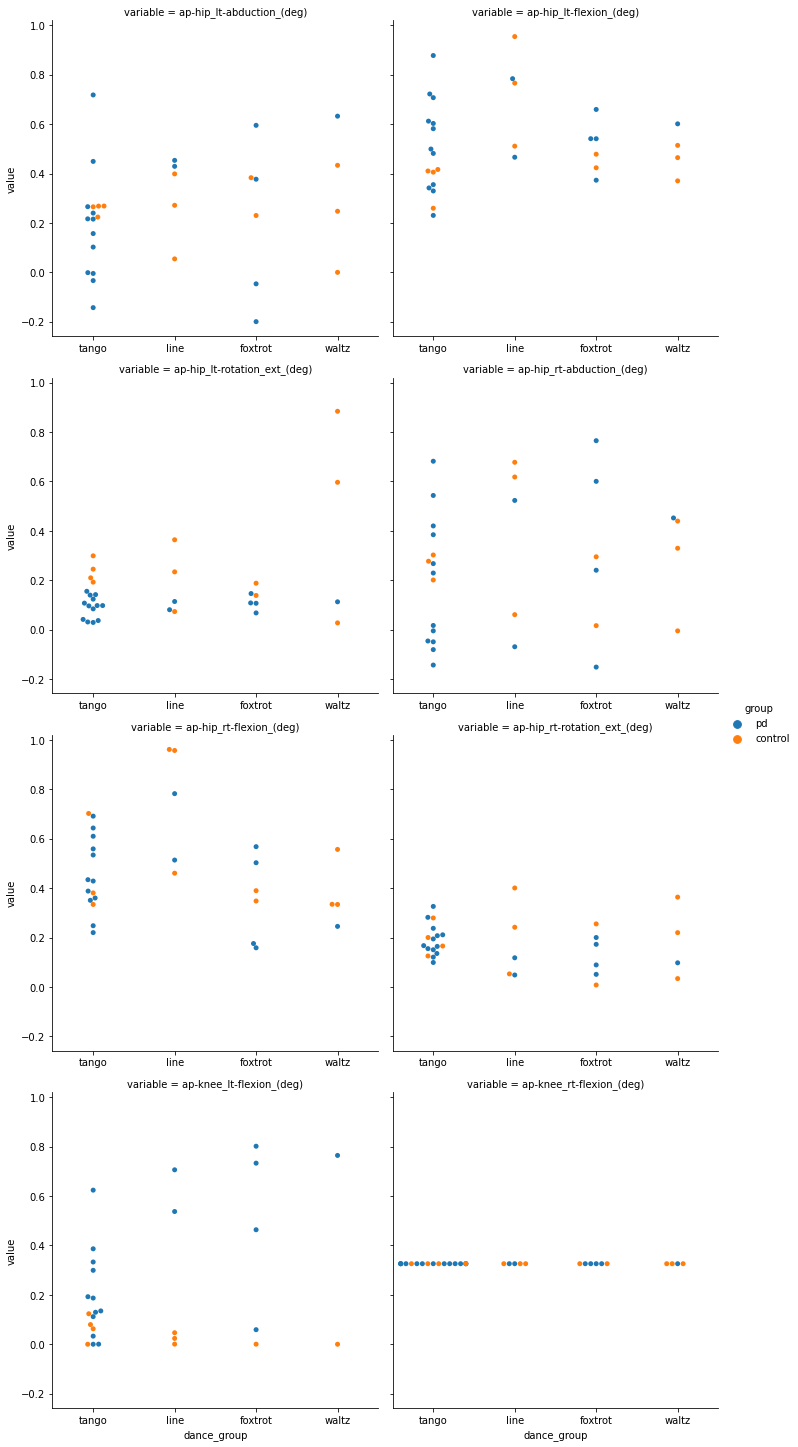

In [14]:
sns.catplot(x='dance_group',y='value',data=var_melt, col='variable', hue='group', kind = 'swarm', col_wrap = 2, sharex=False)

## With Tau = 30

In [6]:
lag2_melt = process_entropy('lag2_entropy')

In [7]:
sns.catplot(x='dance_group',y='value',data=lag2_melt, col='variable', hue='group', kind = 'box', col_wrap = 2, sharex=False)

AttributeError: 'tuple' object has no attribute 'get'

# Segments

In [ ]:
df = pd.read_csv('raw_data_merged/segments_proccessed.csv')

In [ ]:
base_cols = ['id', 'group', 'date','dance','time','marker']
ll_cols = [col for col in df.columns if ('acceleration' in col) & 
                  (('thigh' in col) | 
                   ('shank' in col) | 
                   ('pelvis' in col))]
lower_limbs = df[base_cols + ll_cols]

In [ ]:
g = sns.FacetGrid(lower_limbs, col='group', row='dance', hue = 'id', sharex=False)
g.map(plt.plot, 'time','pelvis-acceleration-x_(mg)')

In [ ]:
lower_limbs.tail()

# Time Domain

In [ ]:
def isolate_variables(part: str, dance:str = 'tango'):
    '''
    Isolates participant and limb measure by dance and date. Checks whether the the date is unique.
    If not unique, returns two dataframes.
    '''
    
    part_df = lower_limbs[(lower_limbs['id']==part) & (lower_limbs['dance']==dance)]
    dates = part_df['date'].unique()
    if len(dates) > 1:
        print(f'{part} has more than one recording of {dance}')
    res = []
    for d in dates:
        temp = part_df[part_df['date']==d]
        res.append(temp)
    return res

In [ ]:
def plot_time_domain(dataframe: pd.DataFrame, col: str):
    '''
    Plots the raw time series. Assume 'time' col.
    
    col is the name of y axis
    '''
    # Time domain
    plt.plot(dataframe['time'],dataframe[col])
    plt.xlabel('Time')
    plt.ylabel(col)

In [ ]:
def format_series(my_series):
    '''
    Just ffills if needed.
    
    NOTE: NaNs are handled by ffill.
    '''
    num_nan = my_series.isna().sum()
    if num_nan > 0:
        print(f"Ffill is used to fill {num_nan} NaNs")
        my_series = my_series.fillna(method='ffill')
    return my_series
    

In [ ]:
pd5 = isolate_variables('pddance005')
pd5 = pd5[0]

In [ ]:
time_x = pd5[['time','pelvis-acceleration-x_(mg)']]
time_x.columns = ['time', 'pelvic_ax']
time_x['pelvic_ax'] = time_x['pelvic_ax'].fillna(method='ffill')

In [ ]:
time_x.head()

In [ ]:
# Time domain
plot_time_domain(time_x, 'pelvic_ax')

## Finding periodocity with ACF

[Time series analysis using pandas in python](https://towardsdatascience.com/time-series-analysis-using-pandas-in-python-f726d87a97d8)

Periodicity = seasonality

In [ ]:
def get_acf(my_series, plot=True):
    '''
    Plots ACF at lags up to full length of dataset
    '''
    from statsmodels import api as sm
    # get the autocorrelation coefficient
    acf = sm.tsa.acf(my_series, nlags=len(my_series), fft=True)
    if plot:
        pd.plotting.autocorrelation_plot(my_series)
    return acf

In [ ]:
from seasonal import fit_seasons
from numpy import tile

#Find seasonality and trend in data
seasonal_pattern, trend = fit_seasons(bike_sharing["cnt"], period=365)
#Fill the seasonal pattern for the entire data for visualization
bike_sharing["seasonality"] = tile(seasonal_pattern, len(bike_sharing)//len(seasonal_pattern) + 1)[:len(bike_sharing)]
bike_sharing["trend"] = trend
#Calculate residual
bike_sharing["residual"] = bike_sharing["cnt"] - bike_sharing["seasonality"] - bike_sharing["trend"]

fig, axes = plt.subplots(nrows=3,
                         ncols=1,
                         sharex=True,
                        figsize=(10,8))

bike_sharing["trend"].plot(ax=axes[0])
axes[0].set_ylabel('Trend')
bike_sharing["seasonality"].plot(ax=axes[1])
axes[1].set_ylabel('Seasonality')
bike_sharing["residual"].plot(ax=axes[2])
axes[2].set_ylabel('Residual')

In [ ]:
acf = get_acf(time_x['pelvic_ax'])

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize = (11,4))
pd.plotting.autocorrelation_plot(time_x['pelvic_ax'], ax=ax[0])
pd.plotting.autocorrelation_plot(time_x['pelvic_ax'], ax=ax[1])
ax[1].set_xlim(0,1000)

* ACF: how correlated time series is with itself at that lag
* Ex: if original time series repeats/cycles every days, there should be a large spike at lag of 2 days

In this plot: Looks like the best autocorrelation is of 0.3 at lag 440ish, with correlational coefficients decreasing to nonsignificant after lag 2000.

So time series repeats every 430ish units.

## Time Series Decomposition

In [ ]:
def decomp_time(my_series):
    'plots the three components of a time series: seasonality, trend, residuals'
    from seasonal import fit_seasons
    from numpy import tile
    
    data = pd.DataFrame({
        'time_series':my_series
    })
    #Find seasonality and trend in data
    seasonal_pattern, trend = fit_seasons(data["time_series"], period=None) # estimate a seasonality pattern
    #Fill the seasonal pattern for the entire data for visualization
    data["seasonality"] = tile(seasonal_pattern, len(time_x)//len(seasonal_pattern) + 1)[:len(time_x)]
    data["trend"] = trend
    #Calculate residual
    data["residual"] = data["time_series"] - data["seasonality"] - data["trend"]

    fig, axes = plt.subplots(nrows=3,
                             ncols=1,
                             sharex=True,
                            figsize=(10,8))

    data["trend"].plot(ax=axes[0])
    axes[0].set_ylabel('Trend')
    data["seasonality"].plot(ax=axes[1])
    axes[1].set_ylabel('Seasonality')
    data["residual"].plot(ax=axes[2])
    axes[2].set_ylabel('Residual')

In [ ]:
deprecated_decomp_time(time_x['pelvic_ax'])

1. Trend: long term movement is stable
2. Seasonality: around 20 units

In [ ]:
def test_stationary(my_series):
    'tests whether time series is stationary. Needed for modeling.'
    from statsmodels.tsa.stattools import adfuller, kpss
    # ADF Test
    result = adfuller(my_series.values, autolag='AIC')
    if result[1] <= 0.05:
        print(f"ADF says it is stationary")
    else:
        print(f"ADF says it is NOT stationary")

    # KPSS Test
    result = kpss(my_series.values, regression='c')
    if result[1] <= 0.05:
        print(f"KPSS says it is NOT stationary")
    else:
        print(f"KPSS says it is stationary")

In [ ]:
test_stationary(pelv)

In [ ]:
def test_seasonality(my_series):
    'tests whether the time series has seasonality'
    print("If ACF plot has repeated spikes at multiples of a window, then seasonality is there")
    

In [ ]:
def plot_acf(my_acf):
    from statsmodels.tsa.stattools import acf, pacf
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

    # Calculate ACF and PACF upto 50 lags
    # acf_50 = acf(df.value, nlags=50)
    # pacf_50 = pacf(df.value, nlags=50)

    # Draw Plot
    fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
    plot_acf(list(my_series), lags=len(my_series), ax=axes[0])
    plot_pacf(list(my_series), lags=len(my_series), ax=axes[1])

In [ ]:
plot_acf(pelv)

# Frequency Content

FFT

In [ ]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft, arange, signal

In [ ]:
# get the frequency and spectrum
f, Pxx = signal.periodogram(time_x['pelvic_ax'], fs = 100, window='hanning', scaling='spectrum')

In [ ]:
plt.plot(f, Pxx)
plt.xlim(0, 10)
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Spectrum Amplitude')

From the spectrum, we can see some peaks, and the corresponding frequency to each peak indicates the periodic signals, and how strong this frequency signal is showing in the spectrum amplitude. The higher the peak, the stronger of this signal repeating itself. 

Let's print out the top 5 peaks, and see how many days corresponding to them.

In [ ]:
# print the top 6 period in the signal
for amp_arg in np.argsort(np.abs(Pxx))[::-1][1:6]:
    day = 1 / f[amp_arg]
    print(day)

# Autocorrelation

[How to create an ARIMA Model](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)

In [ ]:
from pandas.plotting import autocorrelation_plot

plt.style.use('ggplot')
autocorrelation_plot(time_x['pelvic_ax'])
plt.ylim(-0.50, 0.50)
plt.show()

Peaks are well outside the significance point (horizontal line is 95% confidence interval)

[Finding periodic signal in time series data](https://qingkaikong.blogspot.com/2017/01/signal-processing-finding-periodic.html)

In [ ]:
from statsmodels import api as sm
# get the autocorrelation coefficient
acf = sm.tsa.acf(time_x['pelvic_ax'], nlags=len(time_x['pelvic_ax']), fft=True)

fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, figsize = (20,5))
lag = np.arange(len(time_x['pelvic_ax']))

for i in [0,1,2,3]:
    ax[i].plot(lag, acf)
    ax[i].set_xlabel('Lags')
    ax[i].set_ylabel('Autocorrelation')
    if i == 1:
        ax[i].set_xlim(0, 12000)
    elif i == 2:
        ax[i].set_xlim(0,2000)
    elif i == 3:
        ax[i].set_xlim(0,100)

In [ ]:
acf_lag = pd.DataFrame({
    'lag':list(lag),
    'acf':list(acf)
})